iTEBD

In [6]:
from quspin.basis import spin_basis_general # Hilbert space spin basis
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from quspin.basis import spin_basis_1d 
from scipy.linalg import expm
np.random.seed(0)
L=16
basis=spin_basis_general(L,)
Ns = basis.Ns 
antiferomagnets=np.zeros(basis.Ns)
Name=''
for j in range(L):
      if j%2==0:
       Name+="0"
      else:
       Name+='1'
array_ind_s=basis.index(basis.state_to_int(Name))
antiferomagnets[array_ind_s]=1.0
print(antiferomagnets)

[0. 0. 0. ... 0. 0. 0.]


In [7]:
import numpy as np

data_type=np.complex128

S_z = np.diag([1.,-1.]).astype(data_type)
S_x =np.array([[0.,1.],[1.,0.]],dtype=data_type)
S_y=np.array([[0.,complex(0,-1.)],[complex(0,1.),0.]],dtype=data_type) #Pauli Matrices

def chi_trunc(chi,Fs,d=2):
  S,V,D = LA.svd(Fs,full_matrices=False)
    
  lam = V[:chi]#/LA.norm(V[:chi])
  norma = 1-LA.norm(lam)
  lam /=LA.norm(lam)

  A=S[:,:chi].reshape(chi,d,chi)
  B=D[:chi].reshape(chi,d,chi)
  
  return A,lam,B
def time_evolution(Gamma_0,Gamma_1,lam_0,lam_1,U,chi):
    Theta=np.einsum("aib,b->aib",Gamma_0,lam_1)
    Theta=np.einsum("aib,bjc->aijc",Theta,Gamma_1)
    Theta=np.einsum("a,aijc->aijc",lam_0,Theta,)
    Theta=np.einsum("aijc,c->aijc",Theta,lam_0)

    Theta=np.einsum("ijkl,aijb->aklb",U,Theta)
    Theta=Theta.reshape(chi*d,chi*d)         

    S,lam_1,D=chi_trunc(chi,Theta)
    vi=np.divide(1.0, lam_0, out=np.zeros_like(lam_0), where=np.abs(lam_0)>=1E-14)
    Gamma_1=np.einsum("aib,b->aib",D,vi)                            
    Gamma_0=np.einsum("a,aib->aib",vi,S) 
    
    return Gamma_0,Gamma_1,lam_1
def iTEBD():
  for ty in range(N):
   
   Gamma[0],Gamma[1],lam[1]=time_evolution(Gamma[0],Gamma[1],lam[0],lam[1],U,chi)
   Gamma[1],Gamma[0],lam[0]=time_evolution(Gamma[1],Gamma[0],lam[1],lam[0],U,chi)
   
   Theta = np.einsum("aib,b,bjc->aijc",Gamma[1],lam[0],Gamma[0])
   Theta = np.einsum("a,aijc,c->aijc",lam[1],Theta,lam[1])
   
   Ene=np.einsum("ik,jm->ikjm",S_z,S_z)
   Ene=np.einsum("aijb,ikjm->akmb",Theta,Ene)
   Energy_iTEBD[ty+1]=np.einsum("akmb,akmb->",Ene,np.conj(Theta))
  

         138198 function calls (134598 primitive calls) in 6.896 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     8550    4.287    0.001    4.287    0.001 {built-in method numpy.core._multiarray_umath.c_einsum}
      900    2.199    0.002    2.240    0.002 E:\Anaconda\lib\site-packages\numpy\linalg\linalg.py:1483(svd)
15750/12150    0.087    0.000    6.708    0.001 {built-in method numpy.core._multiarray_umath.implement_array_function}
      900    0.062    0.000    5.116    0.006 <ipython-input-7-2a08373198c1>:20(time_evolution)
      900    0.043    0.000    2.372    0.003 <ipython-input-7-2a08373198c1>:9(chi_trunc)
        1    0.042    0.042    6.895    6.895 <ipython-input-7-2a08373198c1>:35(iTEBD)
     1800    0.036    0.000    0.068    0.000 E:\Anaconda\lib\site-packages\numpy\linalg\linalg.py:2363(norm)
     8550    0.019    0.000    4.383    0.001 <__array_function__ internals>:2(einsum)
    43650    0.014    0

E:\Anaconda\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


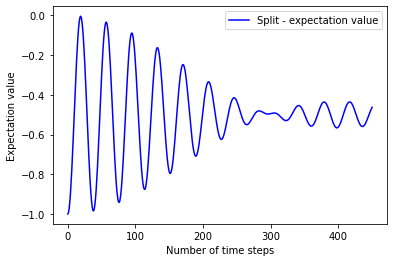

In [8]:
import cProfile
import pstats
T = 2.5*2    # total time
N = 75*6     # Number of updates
dt=T/N       # time step

chi=40              # Bond dimension
d=2                                  # Dimension of physical index
Jzz=0.29#np.exp(1.21)                # zz interaction
Jxx=0.                               # xx interaction
hx=np.sqrt(3)                        # x interaction
hy=np.log(2)                         # y interaction

# Initial state
Gamma_0=np.zeros((chi,d,chi)).astype(complex)
Gamma_0[0,0,0]=1.+0j

Gamma_0/=LA.norm(Gamma_0)
Gamma_1=np.zeros((chi,d,chi)).astype(complex)
Gamma_1[0,1,0]=1.+0j

Gamma_1/=LA.norm(Gamma_1)

Gamma=[Gamma_0,Gamma_1]

lama=np.zeros(chi)
lama[0]=1.
lam=[lama,lama]

# Hamiltonian
H=np.einsum("ij,kl->ikjl",Jzz*S_z,S_z) #two-site

H+=np.einsum("ij,kl->ikjl",Jxx*S_x,S_x) 

H+=np.einsum("ij,kl->ikjl",hy*S_y,np.diag(np.ones(2)))    #on-site
H+=np.einsum("ij,kl->ikjl",np.diag(np.ones(2)),hy*S_y)

H+=np.einsum("ij,kl->ikjl",hx*S_x,np.diag(np.ones(2)))    #on-site
H+=np.einsum("ij,kl->ikjl",np.diag(np.ones(2)),hx*S_x)

# Time evolution operator
U=expm(-1j*dt*H.reshape(d**2,-1)).reshape(d,d,d,d)
# 2 site wave funciotn
Theta = np.einsum("a,aib,b,bjc,c->aijc",lam[0],Gamma[0],lam[1],Gamma[1],lam[0])

Energy_iTEBD=np.zeros(N+1).astype(data_type)
Energy_iTEBD[0]=np.einsum("aijb,ik,jm,akmb->",Theta,S_z,S_z,np.conj(Theta))

# Profile and Execute function
profiler = cProfile.Profile()
profiler.enable()

iTEBD()              # Main code

profiler.disable()
stats = pstats.Stats(profiler).sort_stats('tottime')
stats.print_stats()


#Plotting 
plt.plot(Energy_iTEBD, '-b',label="Split - expectation value")
plt.legend()
plt.xlabel("Number of time steps")
plt.ylabel("Expectation value")
plt.show()

Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


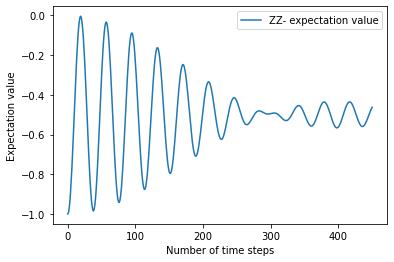

In [9]:
from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.tools.evolution import expm_multiply_parallel # expm_multiply_parallel
#  Quspin evolution

L=16   # system size
np.random.seed(0)   # random seed
basis = spin_basis_1d(L,pauli=1,)     # Hilbert space of spin 1/2                              


Jzz=0.29        # zz interaction
Jxx=0.           # xx interaction
hx=np.sqrt(3)*2               # x interaction
hy=np.log(2)*2                # y interaction
                
J_zz  = [[Jzz,i,(i+1)%L] for i in range(L)] 
J_xx  = [[Jxx,i,(i+1)%L] for i in range(L)]
J_zz1 = [[1.,i,(i+1)%L] for i in range(L)]


h_x=[[hx,i] for i in range(L)]
h_y=[[hy,i] for i in range(L)]

static_H = [["xx",J_xx],["zz",J_zz],["x",h_x],["y",h_y]] #HAMILTONIAN
static_O = [["zz",J_zz1]]       # Observable
dynamic=[]


Fs=antiferomagnets.astype(complex)
#Fs = np.ones(2**L).astype(complex)
#Fs/=LA.norm(Fs)

H = hamiltonian(static_H,dynamic,basis=basis)   #HAMILTONIAN
O = hamiltonian(static_O,dynamic,basis=basis)   #OBSERVABLE

expectation_O = np.zeros(N+1,dtype=np.float64)
expectation_O[0] = O.expt_value(Fs).real

exp_H = expm_multiply_parallel(H.tocsr(),a=-1j*dt)  #Time evolution operator
for d in range(N):

  exp_H.dot(Fs,overwrite_v=True)    #evolve
  expectation_O[d+1] = O.expt_value(Fs).real   #measure observable
  
#Plotting

plt.plot(expectation_O/(L),label="ZZ- expectation value")

plt.legend()
plt.xlabel("Number of time steps")
plt.ylabel("Expectation value")
plt.show()


E:\Anaconda\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


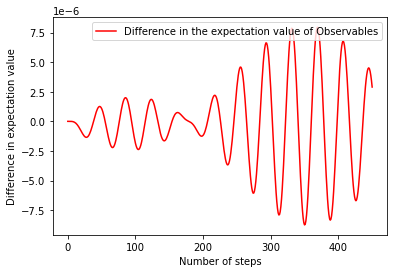

In [12]:
#Checking the observables

plt.plot(expectation_O/L-Energy_iTEBD,'r',label="Difference in the expectation value of Observables")
plt.legend()
plt.xlabel("Number of steps")
plt.ylabel("Difference in expectation value")
plt.show()